# How to extract the gauges from the data

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd
import geopandas as gpd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

In [29]:
data_dir = Path("/datadrive/data")
cwat_dir = data_dir / "CWATM"
output_dir = data_dir / "cwatm_new_basins"

ds = xr.open_dataset(data_dir / "cwatm_ORIG_GRID.nc")
ds["basin"] = ds["basin"].astype(int)

static = xr.open_dataset(data_dir / "cwatm_static.nc")
static = static.rename({"basin": "station_id"})

In [3]:
nc_files = list(output_dir.glob("*.nc"))
print([f.name for f in nc_files])
all_ds = [xr.open_dataset(f) for f in nc_files if "target" not in f.name]

basin_coord = "basin"
# get only the matching station_ids 
list_of_sids = [all_ds[i][basin_coord].values for i in range(len(all_ds))]
shortest_sids_idx = np.argmin([len(lst) for lst in list_of_sids])
sids = list_of_sids[shortest_sids_idx]
ds_ = xr.merge([ds_.sel({basin_coord: sids}) for ds_ in all_ds])
ds_[basin_coord] = ds_[basin_coord].astype(int)
ds_

['input_data.nc', 'target_data.nc', 'hidden_data.nc']


<xarray.Dataset>
Dimensions:            (basin: 864, time: 9131)
Coordinates:
  * time               (time) datetime64[ns] 1990-01-01 ... 2014-12-31
  * basin              (basin) int64 0 1 2 3 4 5 6 ... 858 859 860 861 862 863
Data variables:
    Precipitation      (basin, time) float32 ...
    Tavg               (basin, time) float32 ...
    channelStorage     (basin, time) float32 ...
    storGroundwater    (basin, time) float32 ...
    sum_interceptStor  (basin, time) float32 ...
    SnowCover          (basin, time) float32 ...
    sum_w1             (basin, time) float32 ...
    sum_w2             (basin, time) float32 ...
    sum_w3             (basin, time) float32 ...

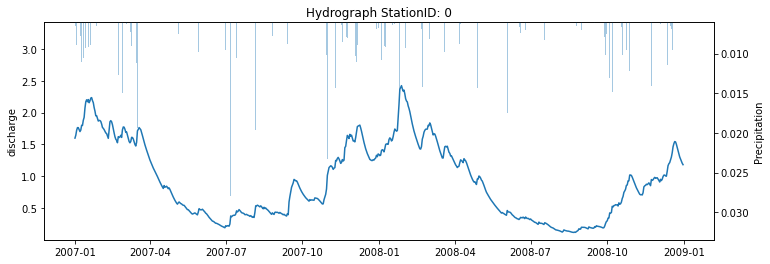

In [4]:
from scripts.plots import plot_hydrograph

discharge_var: str = "discharge"; precip_var: str = "Precipitation"; time_var: str = "time"; basin_dim: str = "basin"
basin = 0
data = ds.sel({basin_dim: basin}).sel(time=slice("2007", "2008"))
plot_hydrograph(data);

<AxesSubplot:>

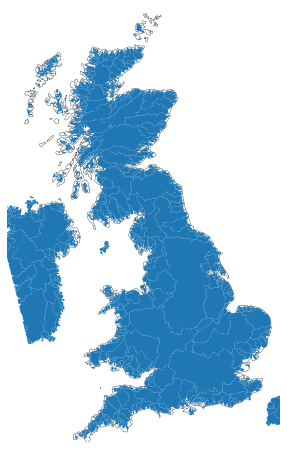

In [5]:
from scripts.geospatial import initialise_gb_spatial_plot


shp_dir = cwat_dir / "shapefile"
basin_shapes = gpd.read_file(list(shp_dir.glob("*.shp"))[0])


ax = initialise_gb_spatial_plot()
basin_shapes = basin_shapes.rename({"value": "basin"}, axis=1)
basin_shapes = basin_shapes.set_index("basin")
basin_shapes.plot(ax=ax)

# make static data

In [6]:
areas = basin_shapes.to_crs("epsg:3035").area

In [7]:
train_start_date, train_end_date = (pd.Timestamp('1990-01-01 00:00:00'), pd.Timestamp('2000-12-31 00:00:00'))
test_start_date, test_end_date = (pd.Timestamp('2001-01-01 00:00:00'), pd.Timestamp('2010-12-31 00:00:00'))

In [8]:
static_df = ds.sel(time=slice(train_start_date, train_end_date)).mean(dim="time").drop("discharge").to_dataframe()
static_df = static_df.rename({c: f"{c}_mean" for c in static_df.columns}, axis=1)
static_df = static_df.join(areas.rename("area"))
static = static_df.dropna().to_xarray()

static["basin"] = static["basin"].astype(int)
# (data_dir / "cwatm_static.nc").unlink()
static.to_netcdf(data_dir / "cwatm_static.nc")

# save list of basin ids to use for training / testing
fname = Path("/home/tommy/neuralhydrology/data/cwatm_basins_list.txt")
np.savetxt(fname, static.basin.values, delimiter="\n", fmt="%d")

static

<xarray.Dataset>
Dimensions:             (basin: 864)
Coordinates:
  * basin               (basin) int64 0 1 2 3 4 5 6 ... 858 859 860 861 862 863
Data variables:
    Precipitation_mean  (basin) float32 0.002819 0.002824 ... 0.001977 0.002113
    Tavg_mean           (basin) float32 7.98 8.156 7.973 ... 10.64 10.95 11.07
    area                (basin) float64 4.1e+07 1.38e+08 ... 3.1e+07 6.7e+07

In [9]:
# # where are they missing data?
# ax = initialise_gb_spatial_plot()
# basin_shapes.loc[np.isnan(static_df["area"]).values].plot(ax=ax)

# Where have the missing basins gone?

In [10]:
from scripts.cwatm_data.ldd_draft import (
    load_basin_file_ldd, delineate_subbasins, get_pour_point_locations_for_basins_from_upstream_area
)
from scripts.cwatm_data.ldd_draft import (
    filter_basins_by_size, _reset_basin_ids, gauge_rowcols_dict_to_xarray, vectorize_rowcol_to_latlon_points
)

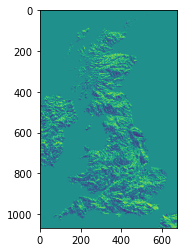

In [11]:
# load ldd data (flow direction)
ldd = load_basin_file_ldd(data_dir)
transform = ldd.rio.transform()
crs = ldd.rio.crs 
latlon = crs.to_epsg() == 4326
flwdir = ldd.values

plt.imshow(flwdir);

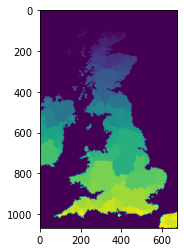

In [12]:
import pyflwdir

min_basin_size = 20
flw = pyflwdir.from_array(flwdir.astype('uint8'), ftype='ldd', cache=True)
basins = flw.basins().astype(np.int32)
basins, _ = filter_basins_by_size(basins, min_basin_size)
basins = _reset_basin_ids(basins)

plt.imshow(basins)

## extract pour points

In [13]:
gauge_rowcols, _ = get_pour_point_locations_for_basins_from_upstream_area(
    basins, flw=flw
)

Calculating basin pour-points: 100%|██████████| 865/865 [00:03<00:00, 273.96it/s]


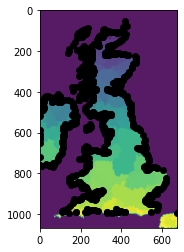

In [14]:
f, ax = plt.subplots(figsize=(15, 4))
ax.imshow(basins, alpha=0.9)
for ix in range(800):
    ax.scatter(gauge_rowcols[ix][0], gauge_rowcols[ix][1], color="k")

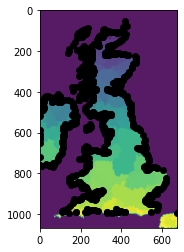

In [15]:
# locations = xr.open_dataset(cwat_dir / "basin_locations.nc")
locations = gauge_rowcols_dict_to_xarray(gauge_rowcols)
locations = locations.sel(basin=slice(0, locations.basin.max()))
locations.to_netcdf(cwat_dir / "basin_locations.nc")

f, ax = plt.subplots(figsize=(15, 4))
ax.imshow(basins, alpha=0.9)
for ix in range(800):
    x, y = locations["location"].isel(basin=ix)
    ax.scatter(x, y, color="k")


In [16]:
target_filepath = output_dir / "target_data.nc"
# all_basins = xr.open_dataset(target_filepath)

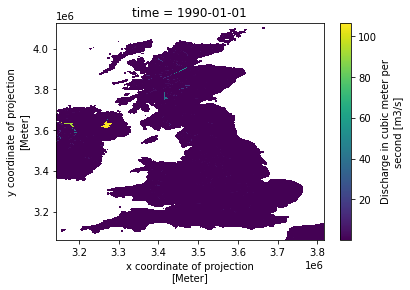

In [17]:
d = xr.open_dataset(data_dir / "CWATM/subset_cwatm.nc")["discharge"]
d.plot()

In [18]:
all_data = []
for basin in locations["location"].basin.values:
    x, y = locations["location"].sel(basin=basin)
    data = d.isel(x=x, y=y).drop(["x", "y"])
    all_data.append(data)
    
all_data = xr.concat(all_data, dim="basin")

In [19]:
print(f"{int(all_data.isnull().sum())} / {len(np.unique(all_data.basin.values))} basins are illigitemate")
print(f"{(float(all_data.isnull().mean()) * 100):.2f}% of basins")

null_basins = list(all_data.where(all_data.isnull(), drop=True)["basin"])

34 / 864 basins are illigitemate
3.94% of basins


In [20]:
shapefile_out_dir = cwat_dir / "shapefile"
list(shapefile_out_dir.iterdir())

[PosixPath('/datadrive/data/CWATM/shapefile/catchment_boundaries.shp'),
 PosixPath('/datadrive/data/CWATM/shapefile/catchment_boundaries.shx'),
 PosixPath('/datadrive/data/CWATM/shapefile/catchment_boundaries.dbf'),
 PosixPath('/datadrive/data/CWATM/shapefile/catchment_boundaries.cpg'),
 PosixPath('/datadrive/data/CWATM/shapefile/catchment_boundaries.prj'),
 PosixPath('/datadrive/data/CWATM/shapefile/station_gauge_locations.shp'),
 PosixPath('/datadrive/data/CWATM/shapefile/station_gauge_locations.shx'),
 PosixPath('/datadrive/data/CWATM/shapefile/station_gauge_locations.dbf'),
 PosixPath('/datadrive/data/CWATM/shapefile/station_gauge_locations.cpg'),
 PosixPath('/datadrive/data/CWATM/shapefile/station_gauge_locations.prj')]

In [88]:
from scripts.cwatm_data.ldd_draft import vectorize_rowcol_to_latlon_points, load_basin_file_ldd
from typing import Dict, Tuple
import rasterio

def vectorize_rowcol_to_latlon_points(
    gauge_rowcols: Dict[str, Tuple[int, int]], ldd: xr.Dataset, crs: int = 3035
) -> gpd.GeoDataFrame:
    # translate rowcol indexes to latlon
    gauge_latlons = {}
    for basin_id, rowcol in gauge_rowcols.items():
        x, y = rowcol
        x_lon = ldd.isel(x=x, y=y)["x"]
        y_lat = ldd.isel(x=x, y=y)["y"]
        gauge_latlons[basin_id] = (x_lon, y_lat)
    
    # convert to GeoSeries
    d = pd.DataFrame(gauge_latlons).rename({0: "lat", 1: "lon"}).T
    points = gpd.GeoSeries(
        gpd.points_from_xy(d["lat"], d["lon"]), index=d.index, crs=crs,
    ).to_crs("epsg:4326")
    points.name = "geometry"
    points = points.to_frame()
    points["original_loc"] = gpd.GeoSeries(gpd.points_from_xy(d["lat"], d["lon"]), index=d.index, crs=crs)
    points["original_x"] = [p.x for p in points["original_loc"]]
    points["original_y"] = [p.y for p in points["original_loc"]]
    points["x"] = [xy[0] for xy in gauge_rowcols.values()]
    points["y"] = [xy[1] for xy in gauge_rowcols.values()]
    points = points.drop("original_loc", axis=1)
    return points


points = vectorize_rowcol_to_latlon_points(gauge_rowcols, ldd=ldd)
ldd_gdf = gpd.read_file(shapefile_out_dir / "catchment_boundaries.shp").set_index("value")

points

,geometry,original_x,original_y,x,y
-1,POINT (-5.04012 58.55442),3451500.0,4031500.0,309,95
0,POINT (-3.31052 59.12991),3562500.0,4074500.0,420,52
1,POINT (-3.25291 58.98012),3562500.0,4057500.0,420,69
2,POINT (-3.07919 58.94213),3571500.0,4051500.0,429,75
3,POINT (-3.38617 58.86645),3552500.0,4046500.0,410,80
...,...,...,...,...,...
859,POINT (2.82329 50.75681),3815500.0,3096500.0,673,1030
860,POINT (2.83567 50.67635),3815500.0,3087500.0,673,1039
861,POINT (1.60891 50.52993),3727500.0,3080500.0,585,1046
862,POINT (2.86162 50.50648),3815500.0,3068500.0,673,1058


In [89]:
# points

In [90]:
ldd = load_basin_file_ldd(cwat_dir)

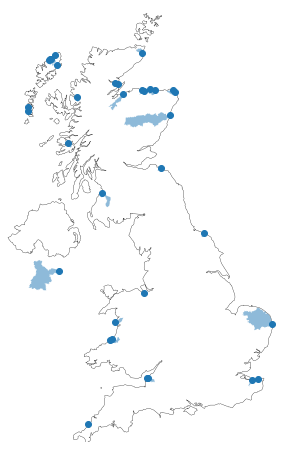

In [91]:
ax = initialise_gb_spatial_plot()
ldd_gdf.loc[null_basins].plot(ax=ax, alpha=0.5)
points.loc[null_basins].plot(ax=ax);

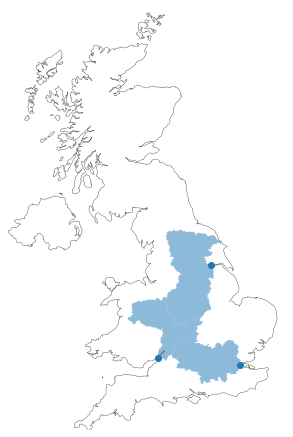

In [92]:
large_sids = static.sortby("area")["area"].station_id[-3:]

ax = initialise_gb_spatial_plot()
ldd_gdf.loc[large_sids].plot(ax=ax, alpha=0.5)
points.loc[large_sids].plot(ax=ax);

In [93]:
[d.name for d in cwat_dir.iterdir()]

['shapefile',
 'shapefile_ALL',
 'basin_mask.nc',
 'discharge_daily.nc',
 'basin_locations.nc',
 'subset_cwatm.nc',
 'ldd.nc',
 'cwatm_output_data_grid.nc',
 'gauge_points']

In [94]:
points_outfile = cwat_dir / "gauge_points"
points = points.reset_index()
points.to_file(points_outfile)